In [1]:
## package imports ##
import sys
import pdkit
sys.path.append("../../src")
import utils.query_utils as query
import synapseclient as sc
import matplotlib.pyplot as plt
from scipy import signal
import warnings
from scipy.fftpack import (rfft, fftfreq)
from scipy.signal import (butter, lfilter, correlate, freqz)
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn import metrics
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.simplefilter("ignore")
sns.set_style("dark")
plt.rcParams['figure.figsize'] = [10, 5]
syn = sc.login()

Welcome, aryton tediarjo!



INFO:synapseclient_default:Welcome, aryton tediarjo!



In [331]:
def butter_lowpass_filter(data, sample_rate, cutoff=10, order=4, plot=False):
    """
        `Low-pass filter <http://stackoverflow.com/questions/25191620/
        creating-lowpass-filter-in-scipy-understanding-methods-and-units>`_ data by the [order]th order zero lag Butterworth filter
        whose cut frequency is set to [cutoff] Hz.
        :param data: time-series data,
        :type data: numpy array of floats
        :param: sample_rate: data sample rate
        :type sample_rate: integer
        :param cutoff: filter cutoff
        :type cutoff: float
        :param order: order
        :type order: integer
        :return y: low-pass-filtered data
        :rtype y: numpy array of floats
        :Examples:
        >>> from mhealthx.signals import butter_lowpass_filter
        >>> data = np.random.random(100)
        >>> sample_rate = 10
        >>> cutoff = 5
        >>> order = 4
        >>> y = butter_lowpass_filter(data, sample_rate, cutoff, order)
    """


    nyquist = 0.5 * sample_rate
    normal_cutoff = cutoff / nyquist
    b, a = butter(order, normal_cutoff, btype='low', analog=False)

    if plot:
        w, h = freqz(b, a, worN=8000)
        plt.subplot(2, 1, 1)
        plt.plot(0.5*sample_rate*w/np.pi, np.abs(h), 'b')
        plt.plot(cutoff, 0.5*np.sqrt(2), 'ko')
        plt.axvline(cutoff, color='k')
        plt.xlim(0, 0.5*sample_rate)
        plt.title("Lowpass Filter Frequency Response")
        plt.xlabel('Frequency [Hz]')
        plt.grid()
        plt.show()

    y = lfilter(b, a, data)

    return y



In [232]:
path_data = query.get_walking_synapse_table(syn, 
                                            "syn12514611", 
                                            "V2", 
                                            healthCodes = ["1fa674e9-2c49-4260-83f0-681ace2a5125", # parkinson
                                                          "c52432c0-754b-4490-b131-9684da102f6c", # control 
                                                          "e8167893-1b3a-4c71-94f4-5b3cb9b52165", # control
                                                          "f80e44ed-ce6f-4aff-8a6a-cfa74c823f6a"]) # parkinson

Querying V2 Data


INFO:synapseclient_default:Downloading 0 files, 212 cached locally


# NOTE:
This notebook will be used to create new gait features by incorporating preliminary signal preprocessing and pdkit gait processors

List of new features:
- Number of steps per seconds based on 2.5 seconds chunking and standard deviation threshold
- Turn Duration 

In [482]:
path_data_subset = path_data
path_data_subset = path_data[path_data["recordId"] == "afd16d07-98f3-40f1-b60e-7790bcc6990b"]
_ts = query.open_filepath(path_data_subset["walk_motion.json_pathfile"].iloc[0])
_ts = query.clean_accelerometer_data(_ts)
gyroscope = _ts[_ts["sensorType"] == "rotationRate"]
acceleration = _ts[_ts["sensorType"] == "accelerometer"]
user_acceleration = _ts[_ts["sensorType"] == "userAcceleration"]

In [509]:

path_data_subset = path_data
path_data_subset = path_data[path_data["recordId"] == "774cd60a-6769-4004-9d71-ab08d84bb958"]
_ts = query.open_filepath(path_data_subset["walk_motion.json_pathfile"].iloc[0])
_ts = query.clean_accelerometer_data(_ts)
gyroscope = _ts[_ts["sensorType"] == "rotationRate"]
acceleration = _ts[_ts["sensorType"] == "accelerometer"]
user_acceleration = _ts[_ts["sensorType"] == "userAcceleration"]

window_size = 256
step_size = 50
jPos = window_size + 1
i = 0
time = []
variances = []

ts = user_acceleration
ts["filtered_y"] = butter_lowpass_filter(ts["y"], sample_rate = 100, cutoff = 2, order = 2)
time = []
heel_strikes = []
while jPos < len(ts):
    jStart = jPos - window_size
    time.append(jPos)
    
    subset = ts.iloc[jStart:jPos]
    
    gp = pdkit.GaitProcessor(duration = subset.td[-1] - subset.td[0],
                            cutoff_frequency = 5,
                            filter_order = 4,
                            delta = 0.5)
    
    var = subset["filtered_y"].var()
    variances.append(var)
    try:
        if (var) < 1e-3:
            heel_strikes.append(0)
        else:
            heel_strikes.append(len(gp.heel_strikes(subset["y"])[1]))
    except:
        heel_strikes.append(0)
    jPos = jPos + step_size
    i = i + 1
    
heel_strikes = np.array(heel_strikes)
variances = np.array(variances)

In [510]:
test = pd.DataFrame({"time":time, "heel_strikes":heel_strikes/(256/100), "variance": variances
             })

In [511]:
test

,time,heel_strikes,variance
0,257,1.953125,0.005352
1,307,1.953125,0.006097
2,357,1.953125,0.006381
3,407,1.562500,0.006261
4,457,1.562500,0.006794
5,507,1.171875,0.007478
6,557,1.562500,0.007672
7,607,0.781250,0.008272
8,657,1.171875,0.008890
9,707,1.562500,0.009281


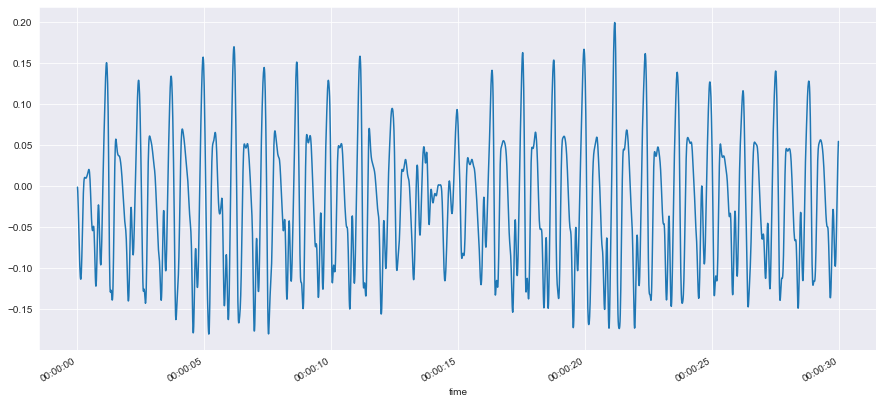

In [512]:
plt.figure(figsize = (15,7))
ts["filtered_y"].plot()
plt.grid()